In [1]:
!pip install jovian opendatasets matplotlib seaborn xgboost --upgrade --quiet


In [2]:
# Import packages
import opendatasets as od
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from datetime import datetime

In [3]:
data_url = 'https://www.kaggle.com/c/g-research-crypto-forecasting/data'
od.download(data_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  georgealexbejinariu


Your Kaggle Key:

  ································


100%|██████████| 1.13G/1.13G [00:08<00:00, 142MB/s] 



Extracting archive ./g-research-crypto-forecasting/g-research-crypto-forecasting.zip to ./g-research-crypto-forecasting


In [4]:
data_dir = './g-research-crypto-forecasting'
os.listdir(data_dir)



['example_sample_submission.csv',
 'gresearch_crypto',
 'supplemental_train.csv',
 'asset_details.csv',
 'example_test.csv',
 'train.csv']

In [11]:
train_df = pd.read_csv('./g-research-crypto-forecasting/train.csv')
asset_details_df = pd.read_csv('./g-research-crypto-forecasting/asset_details.csv')
test_df = pd.read_csv('./g-research-crypto-forecasting/example_test.csv')

In [50]:
train_df['timestamp'] = train_df.timestamp.astype('datetime64[s]')
train_df = train_df[train_df.timestamp.dt.year==2020]
train_df = train_df[train_df.timestamp.dt.month==5]
train_df['timestamp'] = train_df.timestamp.astype('int64')
train_df.shape
df = train_df

(330400, 7)

## RNN-LSTM Crypto-forcasting


In [13]:
import os
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import tensorflow as tf
from sklearn import metrics
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
print(tf.__version__)

2.6.3


## Missing data

In [14]:
train_df.dropna(inplace=True)
train_df = train_df[np.isfinite(train_df).all(1)]

In [18]:
train_df.shape
df=train_df

In [19]:
df.isin([np.nan, np.inf, -np.inf]).sum()


timestamp    0
Asset_ID     0
Count        0
Open         0
High         0
Low          0
Close        0
Volume       0
VWAP         0
Target       0
dtype: int64

In [20]:
df.dropna(inplace=True)
df = train_df[np.isfinite(train_df).all(1)]

In [ ]:
24236806//10 

In [ ]:
df = train_df[-2423680:]

In [21]:
for i in range(0,14):
    train_df[train_df["Asset_ID"] ==i].reindex(range(train_df[train_df["Asset_ID"] ==i].index[0],train_df[train_df["Asset_ID"] ==i].index[-1]+60,60),method='pad')
df=train_df

## Train test split

In [22]:
from sklearn.model_selection import train_test_split

def mysplit(df,features, **split_para):
    df = df[features]
    train_df,val_df = train_test_split(df,train_size=split_para['train_size'],
                                                test_size=split_para['val_size'],shuffle=False)
    #holdout/test sets
    n = len(df) #rows
    test_start = int(n*(1-split_para['train_size']-split_para['val_size']))
    test_df = df[test_start:]

    return train_df, val_df, test_df

In [23]:
train_df, val_df, test_df = mysplit(df= df, features =['Count','Open','High','Low','Close','Volume','VWAP']
                                    ,train_size=0.7,val_size=0.2)

In [24]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std #scipy.stats.zscore(train_df,ddof=1)
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [25]:
train_df.head()


,Count,Open,High,Low,Close,Volume,VWAP
14197663,-0.088510,-0.324677,-0.324676,-0.324680,-0.324676,2.381720,-0.324676
14197664,0.124375,-0.226971,-0.226760,-0.226927,-0.226862,-0.216110,-0.226851
14197665,-0.140913,-0.318067,-0.318064,-0.318073,-0.318071,-0.210001,-0.318068
14197666,4.719420,3.043999,3.057491,3.039372,3.050052,-0.216117,3.050111
14197667,-0.329234,-0.324694,-0.324693,-0.324698,-0.324694,0.304807,-0.324694


## Writting the model

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#########################initial the class
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, train_df, val_df, test_df,
               label_columns=None,**kwargs):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window width.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift #offset size
    self.total_window_size = input_width + shift

    #input/label index and slice
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    ##display output
    return '\n'.join([
        f'Input width={self.input_width},Label width={self.label_width},Offset width={self.shift}',
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

##############################methods: make_dataset
def split_window(self, features):
  '''
  Given a list of consecutive inputs, the split_window method will convert 
        them to a window of inputs and a window of labels.
  '''
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

def make_dataset(self, data):
  '''
  take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs 
    using the `preprocessing.timeseries_dataset_from_array`.
  `timeseries_dataset_from_array`: Creates a dataset of sliding windows over a timeseries provided as array.
      - `batch_size` only matters when want to control the size of the sample network read in at each time.
      - a batch results in only one update to the model.
  '''
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
  #splits input and label over all batchs in the ds
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
##############################add method as property
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  '''
  split with validation part helps the overfitting problem
  '''
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
##############################add method plot as property
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [m]')

WindowGenerator.plot = plot

In [27]:
import tensorflow as tf
from datetime import datetime

def compile_and_fit(model, window, **compilefitpara):
  '''
  model could be a pretrained or new 
  '''
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=2,
                                                      mode='min',restore_best_weights=False)
  #Configures the model for training.
  if 'pretrained' not in compilefitpara:
    print('Compile...')
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),'mse'])
    print('Train...')
    history = model.fit(window.train, epochs=compilefitpara['MAX_EPOCHS'],
                        validation_data=window.val,
                        verbose = compilefitpara['verbose'],
                        callbacks=[early_stopping])
  elif compilefitpara['pretrained']:
    print('Updating pretrained model...')
    history = model.fit(window.train, epochs=compilefitpara['MAX_EPOCHS'],
                            validation_data=window.val,
                            verbose = 0,
                            callbacks=[early_stopping])
  return history

In [28]:
'''
windowing + model.compile+model.fit
'''


def mymodel():
    '''
    design the base lstm models for compile and fit
    '''
    model_list = []
    ## model1 single time-step
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = 20, return_sequences=True,
                            activation='tanh', recurrent_activation='sigmoid'))
    model.add(tf.keras.layers.Dense(units=1))
    model_list.append(model)
    ## model2 multiple time-step
    
    return model_list

def myfittedmodel(model,**windowpara):
    # windowing
    wide_window = WindowGenerator(**windowpara)
    # fit the model
    if 'type' not in windowpara:
        history = compile_and_fit(model = model, window = wide_window, 
                                    MAX_EPOCHS = 2,verbose=0)
    elif windowpara['type'] =='update':
        history = compile_and_fit(model = model, window = wide_window, 
                                    MAX_EPOCHS = 2,verbose=0, pretrained=True)
    return wide_window,model

## Model design and fit


In [29]:
#model design and fit

mylstm = mymodel()
wide_window,lstm_model = myfittedmodel(model = mylstm[0], input_width=30, label_width=30, shift=1,
                                                train_df=train_df, val_df=val_df, test_df=test_df,
                                                label_columns=['Close'])
IPython.display.clear_output()

In [30]:
print('Input shape:', wide_window.example[0].shape)#[batch_size, timesteps, feature]
print('Output shape:', lstm_model(inputs= wide_window.example[0]).shape)
print('Label shape:', wide_window.example[1].shape)

Input shape: (32, 30, 7)
Output shape: (32, 30, 1)
Label shape: (32, 30, 1)


### Visualizing the architecture

In [31]:
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 20)            2240      
_________________________________________________________________
dense (Dense)                (None, 30, 1)             21        
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
_________________________________________________________________


### Performence Metric

In [32]:
val_performance={}
performance={}
val_performance['LSTM0'] = lstm_model.evaluate(x = wide_window.val,verbose=0)
performance['LSTM0'] = lstm_model.evaluate(wide_window.test, verbose=0,return_dict=False)
lstm_model.metrics_names


['loss', 'mean_absolute_error', 'mse']

In [33]:
performance['LSTM0']#test evaluation

[0.03730480372905731, 0.0484514981508255, 0.03730481117963791]

In [34]:
val_performance['LSTM0']#val/train evaluation

[0.03468173369765282, 0.043055176734924316, 0.03468181937932968]

In [35]:
print("Validation MSE:", val_performance['LSTM0'][2])
print("Test MSE:",performance['LSTM0'][2] )

Validation MSE: 0.03468181937932968
Test MSE: 0.03730481117963791


### tf.keras.loss version

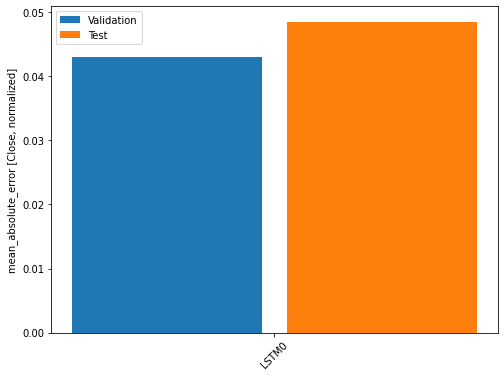

In [36]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
mae_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[mae_index] for v in val_performance.values()]
test_mae = [v[mae_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [37]:
# save entire network to HDF5 
save_path = "/D:/Master/RNN_Crypto"
lstm_model.save(os.path.join(save_path,"lstm-base.h5"))

### K-fold CrossValidation for hyperparameters

In [38]:
import numpy  as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

class BlockingTimeSeriesSplit():
    '''
    1.Blockingbased sklearn.model_selection.TimeSeriesSplit
    2.offer train_df and val_df into WindowGenerator
    '''
    def __init__(self, n_splits, X):
        self.n_splits = n_splits
        self.X = X
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X=None, y=None, groups=None):
        x_none = getattr(self, 'X', None)
        if x_none is not None:
            n_samples = len(self.X)
        else:
            #in case of TimeSeriesSplit
            n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            #return a generator
            train_ind, test_ind = indices[start: mid], indices[mid + margin: stop]
            yield train_ind, test_ind



########################################visualize the split
def plot_cv_indices(cv, X,y=None, lw=10):
    """
    Create a sample plot for indices of a cross-validation object.
    https://goldinlocks.github.io/Time-Series-Cross-Validation/
    """
    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm
    fig, ax = plt.subplots(figsize=(10, 5))
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                c=indices, marker='_', lw=lw, cmap=cmap_cv,
                vmin=-.2, vmax=1.2)

    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
            c=y, marker='_', lw=lw, cmap=cmap_data)
    ax.set_title(f'{type(cv).__name__}', fontsize=15)
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
        ['Testing set', 'Training set'], loc=(1.02, .8))
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
    plt.show()

####################################test

(87409, 10) (87407, 10)
(174816, 10) (87407, 10)
(262223, 10) (87407, 10)
(349630, 10) (87407, 10)
(437037, 10) (87407, 10)


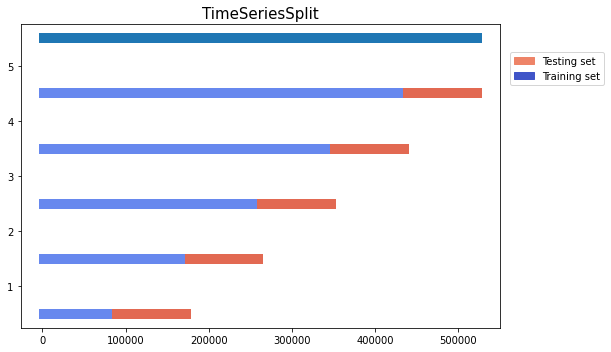

In [39]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tscv.split(X=df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    print(cv_train.shape,cv_test.shape)

plot_cv_indices(tscv,X=df)

(52444, 10) (52444, 10)
(52444, 10) (52444, 10)
(52444, 10) (52444, 10)
(52444, 10) (52444, 10)
(52444, 10) (52444, 10)


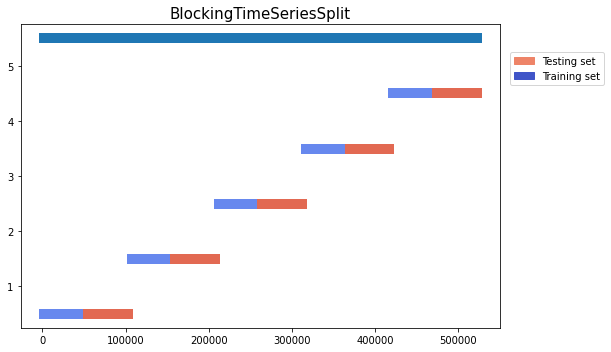

In [40]:
tscv = BlockingTimeSeriesSplit(n_splits = 5, X=df)
for train_index, test_index in tscv.split(X=df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    print(cv_train.shape,cv_test.shape)
plot_cv_indices(tscv, X=tscv.X)

In [41]:


import tensorflow as tf
import numpy as np
from sklearn import metrics
import itertools

def blockkfoldcv(df,K,model,withholdout:bool=True,holdoutpct=0.1):
    '''
    return the k-fold metrics on the model
    '''
    if withholdout:
        #holdout/test sets
        n = len(df)
        test_df = df[int(n*(1-holdoutpct)):]
        tscv = BlockingTimeSeriesSplit(n_splits = K,X=df[:int(n*(1-holdoutpct))])
    else:
        tscv = BlockingTimeSeriesSplit(n_splits = K,X=df)
    fold = 0
    oos_y = []
    oos_pred = []
    fold_score=[]
    #k-fold loop
    for train_index, val_index in tscv.split():
        fold+=1
        print(f"Fold #{fold}")
        #train, validation sets in the fold
        cv_train, cv_val = df.iloc[train_index], df.iloc[val_index]
        num_features = df.shape[1]
        #normalization
        train_mean = cv_train.mean()
        train_std = cv_train.std()
        cv_train = (cv_train - train_mean) / train_std #scipy.stats.zscore(train_df,ddof=1)
        cv_val = (cv_val - train_mean) / train_std
        if withholdout:
            test_df = (test_df - train_mean) / train_std
        #fit model
        wide_window,lstm_model = myfittedmodel(model=model,
                                                input_width=30, label_width=30, shift=1,
                                                train_df=cv_train, val_df=cv_val, test_df=test_df,
                                                label_columns=['Close'],fit=True)

        # Measure MSE error for this fold
        score = lstm_model.evaluate(wide_window.val, verbose=0,return_dict=True)
        fold_score.append(score['mse'])
        print(f"Fold score (MSE): {score['mse']}")

        # prediction on validation set
        pred = []
        label = []
        for input_batch,label_batch in wide_window.val:
            pred_batch = lstm_model(input_batch)
            pred.append(list(pred_batch.numpy().flatten()))
            label.append(list(label_batch.numpy().flatten()))
        #flatten list of lists
        pred = np.array(list(itertools.chain(*pred)))
        label = np.array(list(itertools.chain(*label)))
        oos_y.append(label)
        oos_pred.append(pred) 
    # Build the oos prediction list and calculate the error.
    oos_y = np.concatenate(oos_y)
    oos_pred = np.concatenate(oos_pred)
    oos_score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
    print(f"Final, out of sample score (RMSE): {oos_score}")  
    return  oos_score

### Training with both a Cross-Validation and a Holdout Set

In [42]:
mylstm = mymodel()
score = blockkfoldcv(df = df, K=3,model=mylstm[0], withholdout=True,holdoutpct=0.1)
IPython.display.clear_output()

print(f"Final, out of sample score (RMSE): {score}")  

Final, out of sample score (RMSE): 0.2557751536369324


## Cross Validation and Holdout set

In [43]:
mylstm = mymodel()
score = blockkfoldcv(df = df, K=3,model=mylstm[0], withholdout=True,holdoutpct=0.1)
IPython.display.clear_output()

print(f"Final, out of sample score (RMSE): {score}")  

Final, out of sample score (RMSE): 0.1909913718700409


## L2 Regularization

In [44]:
from tensorflow.keras import regularizers
# model design with l2 regulizers
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 20, return_sequences=True,activity_regularizer=regularizers.l2(1e-5),
                        activation='tanh', recurrent_activation='sigmoid'),#Recurrent layers
    tf.keras.layers.Dense(units=1)#densely-connected NN layer: output with dim-1
])

## Drop Out for Keras to Decrease Overfitting
Dropout works by causing hidden neurons of the neural network to be unavailable during part of the training. Dropping part of the neural network causes the remaining portion to be trained to still achieve a good score even without the dropped neurons. This decreases coadaption between neurons, which results in less overfitting.

In [45]:
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from bayes_opt import BayesianOptimization

In [46]:
# reload
lstm_base= tf.keras.models.load_model(os.path.join(save_path,"lstm-base.h5"))
IPython.display.clear_output()

In [47]:
#train, validation sets
train_df, val_df, test_df = mysplit(df= df,features =['Count','Open','High','Low','Close','Volume','VWAP'], train_size=0.7,val_size=0.2)
train_df, val_df, test_df = mysplit(df= test_df,features =['Count','Open','High','Low','Close','Volume','VWAP'], train_size=0.7,val_size=0.2)

train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [48]:
window_updated,lstm_updated = myfittedmodel(model = lstm_base, input_width=30, label_width=30, shift=1,
                                                train_df=train_df, val_df=val_df, test_df=test_df,
                                                label_columns=['Close'], 
                                                type='update')
IPython.display.clear_output()

In [49]:
lstm_updated.evaluate(x = window_updated.test,verbose=1)

13275/13275 [==============================] - 70s 5ms/step - loss: 0.0357 - mean_absolute_error: 0.0427 - mse: 0.0357


[0.03565581142902374, 0.042682114988565445, 0.035655856132507324]